In [ ]:
#@title
# import required libraries

import pandas as pd # dataframes
import numpy as np #mathematical operations

# to visualise

import plotly.express as px # plotly
from wordcloud import WordCloud # wordclouds
import matplotlib.pyplot as plt #matplot
import seaborn as sns #seaborn
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Vectorisation

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Treating class imbalanced data

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# model building

from sklearn.model_selection import train_test_split

# algorithms

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# checking up with models

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

<h3 style= "color:blue;"> Importing Data Set </h3>

In [ ]:
# landing google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load your dataframe
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Research/Method 2 - Titles/preprocessed_title_OVR.csv",index_col=[0])

In [ ]:
# change both types into string
df['Title'] = df['Title'].astype('str')
df['Intervention Area'] = df['Intervention Area'].astype('str') 

<h3> Size </h3>

In [ ]:
unique_values = df['Intervention Area'].unique()
print(unique_values)

['Digital Information Services' 'Policy & Regulation or Digital Services'
 'Digital Infrastructure Development' 'Cybersecurity'
 'Data Systems & Development' 'Digital Literacy' 'E-government'
 'Digital Inclusion' 'Digital Finance' 'Child Protection'
 'Upskilling/ Capacity Building' 'Data Privacy']


In [ ]:
# Replace DigitalFinance value with 1
df.loc[df["Intervention Area"] == "Digital Finance", "Intervention Area"] = 1
df.head(5)

,Title,Intervention Area
0,aarogya setu mobile application monitor mitiga...,Digital Information Services
1,online teach ict post covid,Policy & Regulation or Digital Services
2,best method family plan text mining analysis m...,Digital Information Services
3,mobile industry impact sustainable goal,Digital Infrastructure Development
4,recommendation governance guide lawmaker regul...,Cybersecurity


In [ ]:
# Replace other values with 0
df.loc[df["Intervention Area"] != 1, "Intervention Area"] = 0

# reorder the dataframe to get childprotection content to appear first
df = df.sort_values(by='Intervention Area', ascending=False)

df.head(5)

,Title,Intervention Area
1002,risk share transaction cost replication study ...,1
868,mobile commerce adoption bottom pyramid street...,1
864,mobile banking answer financial inclusion hill...,1
1081,tame strange beast service future paygo,1
255,cybersecurity mobile financial service,1


In [ ]:
# check if there are duplicates
df.duplicated(subset=['Title']).any() #duplicates

True

Which means there are duplicates at the moment.

In [ ]:
# remove duplicates, leaving the first record
df = df.drop_duplicates(subset=['Title'],keep="first")

In [ ]:
# spread of text files after removing duplicates
# Count the number of items per group
group_counts = df.groupby("Intervention Area").count()
group_counts=group_counts.reset_index()

# Create the bar chart
fig = px.bar(group_counts, x='Intervention Area', y='Title',color="Intervention Area")

# Show the chart
fig.show()

<h3> Word Cloud </h3>

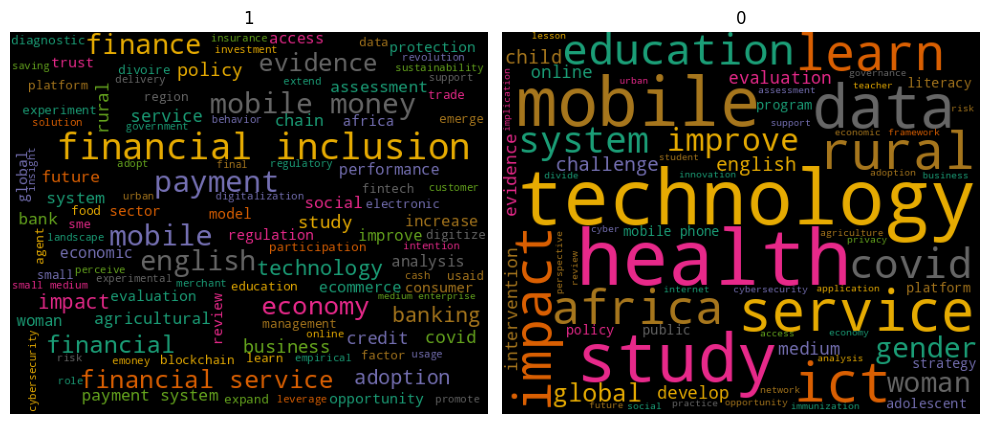

In [ ]:
# word clouds based on intervention areas

# Get all the unique classes in the dataset
classes = df['Intervention Area'].unique()

# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.ravel()

# Iterate through each class
for i, class_name in enumerate(classes):
    # Get all the text for the current class
    class_text = df[df['Intervention Area'] == class_name]['Title'].str.cat(sep=' ')
    # Generate the wordcloud
    wordcloud = WordCloud(width = 500, height = 400, 
                colormap="Dark2",
                min_font_size = 10).generate(class_text) 
    # Plot the wordcloud
    axs[i].imshow(wordcloud) 
    axs[i].set_title(f"{class_name}") 
    axs[i].axis("off") 
fig.tight_layout()
plt.show()

<b> Now we have to vectorise our content column </b>

In [ ]:
# vectorsing the content column
vectorizer = TfidfVectorizer(stop_words=None)
vectorized_df = vectorizer.fit_transform(df['Title'])
# defining the y label
y = df['Intervention Area']
y=y.astype('int')
y=y.to_frame()

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
# Filter the dataframe to include only class 0 samples
class_0_df = df[df['Intervention Area'] == 0]

# Concatenate the text data from class 0 samples into a single string
class_0_text = ' '.join(class_0_df['Title'])

# Tokenize and filter the text data from class 0 samples
class_0_tokens = nltk.word_tokenize(class_0_text)

# Count the frequency of each word in class 0
class_0_word_freq = nltk.FreqDist(class_0_tokens)

# Filter the dataframe to include only class 1 samples
class_1_df = df[df['Intervention Area'] == 1]

# Concatenate the text data from class 1 samples into a single string
class_1_text = ' '.join(class_1_df['Title'])

# Tokenize and filter the text data from class 1 samples
class_1_tokens = nltk.word_tokenize(class_1_text)

# Count the frequency of each word in class 1
class_1_word_freq = nltk.FreqDist(class_1_tokens)

# Get the keywords that are common in class 1 but not common in class 0
k = 10  # Specify the desired number of keywords
keywords = []

for word, frequency in class_1_word_freq.items():
    if word in class_0_word_freq:
        if frequency > class_0_word_freq[word]:
            keywords.append((word, frequency))

# Sort the keywords by frequency in descending order
keywords.sort(key=lambda x: x[1], reverse=True)


# Print the top keywords
for keyword, frequency in keywords[:k]:
    print(keyword, frequency)

financial 67
inclusion 37
payment 30
money 22
finance 20
economy 17
chain 7
performance 6
ecommerce 6
trust 5


In [ ]:
keywords= ['financial','inclusion','payment','money','finance']

In [ ]:
for keyword in keywords:
    df.loc[df['Title'].str.contains(keyword, case=False, na=False), keyword] = 1
    df.loc[~df['Title'].str.contains(keyword, case=False, na=False), keyword] = 0

In [ ]:
from scipy.sparse import hstack

# Concatenate the binary features with the vectorized features
X = hstack([vectorized_df, df[keywords].values])

<h3 style= "color:blue;"> Defining train and test set </h3>

In [ ]:
# train test split
X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

<b> Finally we can get rid of class imbalanced data</b> - OVERSAMPLING

In [ ]:
# treat class imbalanced data
ros = RandomOverSampler(random_state=42)
X_trainro, Y_trainro = ros.fit_resample(X_train, Y_train)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_trainru, Y_trainru = rus.fit_resample(X_train, Y_train)

<h3> Decision Trees </h3>

In [ ]:
# fit the model
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, Y_train.values.ravel())

# make predictions
pred_dt = dt.predict(x_test)

# print accuracy 
print("Accuracy %s" % accuracy_score(pred_dt,y_test))

Accuracy 0.8181818181818182


In [ ]:
print(classification_report(y_test,pred_dt))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       180
           1       0.62      0.76      0.68        62

    accuracy                           0.82       242
   macro avg       0.76      0.80      0.78       242
weighted avg       0.84      0.82      0.82       242



<h3> Naive Bayes </h3>

In [ ]:
# fit the model
nb = MultinomialNB()
nb.fit(X_trainro, Y_trainro.values.ravel())

# make predictions 
pred_nb = nb.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_nb,y_test))

Accuracy 0.8016528925619835


In [ ]:
print(classification_report(y_test,pred_nb))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       180
           1       0.59      0.76      0.66        62

    accuracy                           0.80       242
   macro avg       0.75      0.79      0.76       242
weighted avg       0.83      0.80      0.81       242



<h3> K-Nearest Neighbours </h3>

In [ ]:
# fit the model
knn = KNeighborsClassifier()
knn.fit(X_trainro,Y_trainro.values.ravel())

# make predictions
pred_knn = knn.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_knn,y_test))

Accuracy 0.78099173553719


In [ ]:
print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       180
           1       0.55      0.74      0.63        62

    accuracy                           0.78       242
   macro avg       0.73      0.77      0.74       242
weighted avg       0.81      0.78      0.79       242



<h3> Logistic Regression </h3>

In [ ]:
# fit the model
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, Y_train.values.ravel())

# make predictions
pred_lr = lr.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_lr,y_test))

Accuracy 0.8677685950413223


In [ ]:
print(classification_report(y_test,pred_lr))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92       180
           1       0.84      0.60      0.70        62

    accuracy                           0.87       242
   macro avg       0.86      0.78      0.81       242
weighted avg       0.87      0.87      0.86       242



<h3> Ada Boost </h3>

In [ ]:
# fit the model
ab = AdaBoostClassifier()
ab.fit(X_trainro, Y_trainro.values.ravel())

# make predictions
pred_ab = ab.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_ab,y_test))

Accuracy 0.8347107438016529


In [ ]:
print(classification_report(y_test,pred_ab))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       180
           1       0.70      0.61      0.66        62

    accuracy                           0.83       242
   macro avg       0.79      0.76      0.77       242
weighted avg       0.83      0.83      0.83       242



<h3> SGD </h3>

In [ ]:
# fit the model
sgd = SGDClassifier(class_weight='balanced')

sgd.fit(X_train, Y_train.values.ravel())

# make predictions
pred_sgd = sgd.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_sgd,y_test))

Accuracy 0.8471074380165289


In [ ]:
print(classification_report(y_test,pred_sgd))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       180
           1       0.71      0.68      0.69        62

    accuracy                           0.85       242
   macro avg       0.80      0.79      0.80       242
weighted avg       0.84      0.85      0.85       242



<h3> Support Vectore Machine </h3>

In [ ]:
# fit the model
svc = SVC(class_weight='balanced')
svc.fit(X_train, Y_train.values.ravel())

# make predictions
pred_svc = svc.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_svc,y_test))

Accuracy 0.8677685950413223


In [ ]:
print(classification_report(y_test,pred_svc))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92       180
           1       0.84      0.60      0.70        62

    accuracy                           0.87       242
   macro avg       0.86      0.78      0.81       242
weighted avg       0.87      0.87      0.86       242



<h3> Ensemble </h3>

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create instances of the SGDClassifier and RandomForestClassifier
lr = LogisticRegression(class_weight='balanced')
svc = SVC(class_weight='balanced')

# Create an instance of the VotingClassifier
ensemble = VotingClassifier(estimators=[('sgd', sgd), ('svc', svc)], voting='hard')

# Fit the VotingClassifier to the data
ensemble.fit(X_train, Y_train.values.ravel())

# Make predictions
pred_ensemble = ensemble.predict(x_test)

# Print accuracy
print("Accuracy %s" % accuracy_score(pred_ensemble, y_test))

Accuracy 0.8677685950413223


In [ ]:
print(classification_report(y_test,pred_ensemble))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       180
           1       0.86      0.58      0.69        62

    accuracy                           0.87       242
   macro avg       0.86      0.77      0.80       242
weighted avg       0.87      0.87      0.86       242



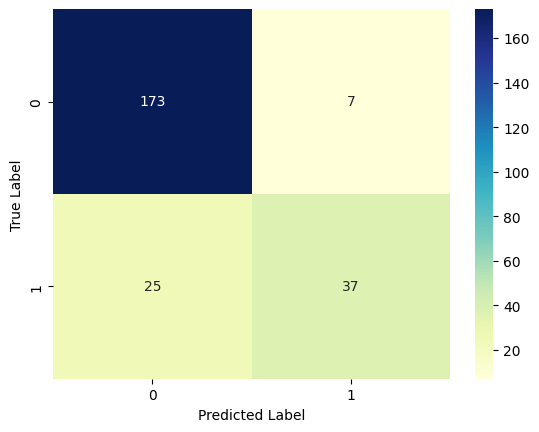

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, pred_lr)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from joblib import Parallel, delayed
import joblib

# Save the model as a pickle in a file
joblib.dump(lr, '/content/drive/MyDrive/Colab Notebooks/Research/digitalfinance.pkl')

['/content/drive/MyDrive/Colab Notebooks/Research/digitalfinance.pkl']